# Author Attribution and Document Clustering Using the Reuters C50 Corpus

This analysis aims to explore and cluster documents from the Reuters C50 corpus based on author attribution. We will utilize TF-IDF vectorization, dimensionality reduction techniques (PCA), and clustering algorithms (K-Means) to uncover patterns in the dataset. Additionally, sentiment analysis will be performed on the documents to gain insights into the tone and sentiment of the texts.

In [1]:
import nltk
import random
import os
import re
import numpy as np
import pandas as pd
from collections import Counter
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import random
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import reuters, stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize, sent_tokenize
import plotly.express as px

## Data Loading and Preprocessing

The dataset is loaded from the Reuters C50 corpus, consisting of 50 articles from each of 50 different authors. The data is divided into training and testing sets. We will preprocess the text data by cleaning it, tokenizing, and vectorizing using the TF-IDF method.

In [2]:
# Download NLTK data (if not already installed)
nltk.download('stopwords')
nltk.download('punkt') # for tokenizing

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pranvgarg/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/pranvgarg/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# Define the data directories
train_dir = "ReutersC50/C50train"  # Update with your path
test_dir = "ReutersC50/C50test"    # Update with your path

In [4]:
# Helper function to read data from a labeled directory
def read_data_from_directory(directory_path):
    texts = []
    labels = []
    authors = os.listdir(directory_path)

    for author in authors:
        author_path = os.path.join(directory_path, author)
        
        # Skip if it is not a directory (e.g., .DS_Store file)
        if not os.path.isdir(author_path):
            continue
        
        for file_name in os.listdir(author_path):
            file_path = os.path.join(author_path, file_name)
            with open(file_path, 'r', encoding='utf-8') as f:
                texts.append(f.read())
                labels.append(author)
                
    return texts, labels

# Reading the training and test data
train_texts, train_labels = read_data_from_directory(train_dir)
test_texts, test_labels = read_data_from_directory(test_dir)
train_df = pd.DataFrame({'document': train_texts, 'author': train_labels})
test_df = pd.DataFrame({'document': test_texts, 'author': test_labels})

## sentiment analysis of whole corpus
Sentiment analysis is conducted to assess the tone of the documents in the dataset. By analyzing the sentiment scores, we can gain insights into the overall mood and sentiment expressed by the authors in their writings.

In [5]:
data_dir = "ReutersC50"
nltk.data.path.append(os.path.abspath(data_dir))
nltk.download('vader_lexicon', download_dir=data_dir)
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to ReutersC50...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [6]:
from tqdm import tqdm
def get_sentiment_scores(text):
    sia = SentimentIntensityAnalyzer()
    sentiment_scores = sia.polarity_scores(text)
    return sentiment_scores

sentiment_scores_list = []

for _, train_text in tqdm(enumerate(train_df['document'])):
    text = train_text
    sentiment_scores = get_sentiment_scores(text)
    sentiment_scores['document'] = train_text
    sentiment_scores_list.append(sentiment_scores)

2500it [00:11, 223.85it/s]


In [7]:
sentiment_df = pd.DataFrame(sentiment_scores_list)
sentiment_df = sentiment_df[['document', 'pos', 'neu', 'neg', 'compound']]
sentiment_df

,document,pos,neu,neg,compound
0,Drugstore giant Revco D.S. Inc. said Monday it...,0.102,0.868,0.030,0.9840
1,"Mattel Inc., seeking to expand in the market f...",0.078,0.898,0.025,0.9824
2,A financial agreement between Barney's Inc and...,0.051,0.906,0.043,0.4959
3,An independent shareholder advisory firm recom...,0.066,0.890,0.043,0.8406
4,Raising the stakes in the escalating battle fo...,0.133,0.811,0.056,0.9930
...,...,...,...,...,...
2495,The Toronto Stock Exchange closed mixed in hea...,0.170,0.755,0.075,0.9888
2496,The Toronto stock market ended weaker in brisk...,0.068,0.889,0.043,0.6096
2497,Toronto stocks ended sharply lower on Thursday...,0.098,0.810,0.092,0.2500
2498,The Toronto stock market ended weaker in brisk...,0.104,0.857,0.039,0.9637


In [8]:
sentiment_scores

{'neg': 0.045,
 'neu': 0.914,
 'pos': 0.041,
 'compound': -0.4594,
 'document': 'Several large-capitalization Canadian stocks could benefit, while others may be hurt when the Toronto Stock Exchange changes rules governing control blocks in its key 300 Composite Index on Friday.\nStocks such as Barrick Gold Corp, funeral home operator Loewen Group Inc and energy firm Petro-Canada should get snapped up by fund managers when the rules change, analysts said.\n"Index funds, which try to match the weighting of the index, are going to have to scramble to buy X percent more Barrick shares...by Friday," said an analyst who declined to be identified.\nThe Toronto Stock Exchange, which handles more than 80 percent of Canada\'s equity trading, will increase the relative weighting of 30 stocks on Friday by raising the level of control blocks to 20 percent from 15 percent.\nThe change will take effect at the start of trading on Friday.\nRelative weighting describes the impact a stock or sub-group ha

### Short Inference:
The sentiment analysis suggests that the majority of the documents in this dataset are neutral in tone, with a slight lean towards positive sentiment. Negative sentiment is minimal but present. The compound scores reflect this, with most documents leaning towards a positive overall sentiment. This might be indicative of the nature of the content, such as corporate announcements or neutral reporting, which tends to avoid extreme emotional tones.

In [9]:
# Helper function to tokenize, remove punctuation, and stem
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
 # Convert text to lowercase
    text = text.lower()
    
    # Remove specific unwanted characters and patterns using regex
    text = re.sub(r"[-'\"`~(){}[\]<>]", " ", text)  # Replace various punctuation and special characters with spaces
    text = re.sub(r"\.{2,}", " ", text)  # Replace ellipses with a space
    text = re.sub(r"\b\w{1,2}\b", "", text)  # Remove words with only 1 or 2 characters
    
    # Remove remaining special characters
    text = re.sub(r"[^\w\s]", "", text)  # Remove any remaining non-alphanumeric characters
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stop words
    tokens = [token for token in tokens if token not in stop_words]
    
    # Stemming
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    
    return stemmed_tokens

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pranvgarg/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Count Vectorization

In [10]:
vectorizer = CountVectorizer(stop_words='english', max_features=1000)
train_dtm = vectorizer.fit_transform(train_df['document'])
test_dtm = vectorizer.transform(test_df['document'])

In [11]:
train_dtm.shape, test_dtm.shape

((2500, 1000), (2500, 1000))

In [12]:
from sklearn.decomposition import LatentDirichletAllocation
# Define the number of topics for LDA on TRAIN TEST
n_topics = 30
lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda_model.fit(train_dtm)

# Initialize a dictionary to store topics and their top words
topic_word_mapping = {}

# Extract feature names and identify top words for each topic
vocab = vectorizer.get_feature_names_out()

for index, topic_distribution in enumerate(lda_model.components_):
    print(f"Topic {index + 1}:")
    
    # Adjusting the slicing to match the vocabulary size
    top_indices = topic_distribution.argsort()[:-min(len(vocab), 10) - 1:-1]
    
    # Make sure indices are within the bounds
    top_terms = [vocab[i] for i in top_indices if i < len(vocab)]
    
    print(top_terms)
    topic_word_mapping[index] = [(index + 1), top_terms]

Topic 1:
['gm', 'workers', 'said', 'ford', 'plant', 'uaw', 'car', 'plants', 'strike', 'chrysler']
Topic 2:
['said', 'service', 'online', 'states', 'ban', 'poultry', 'united', 'access', 'new', 'america']
Topic 3:
['said', 'city', 'office', 'congress', 'site', 'new', 'banks', 'building', 'pacific', 'bank']
Topic 4:
['bid', 'pence', 'said', 'offer', 'electric', 'northern', 'price', 'electricity', 'share', 'power']
Topic 5:
['amp', 'communications', 'cable', 'said', 'local', 'new', 'phone', 'long', 'fcc', 'tv']
Topic 6:
['said', 'new', 'asia', 'australia', 'airlines', 'europe', 'pacific', 'asian', 'international', 'services']
Topic 7:
['said', 'china', 'beijing', 'chinese', 'taiwan', 'officials', 'trade', 'foreign', 'united', 'states']
Topic 8:
['mci', 'bt', 'said', 'fund', 'british', 'market', 'deal', 'billion', 'percent', 'funds']
Topic 9:
['said', 'law', 'industry', 'court', 'state', 'companies', 'tobacco', 'rules', 'government', 'case']
Topic 10:
['gold', 'said', 'bre', 'toronto', 'bar

In [13]:
# Function to predict the most likely topic for a new document
def determine_topic(document):
    # Convert the document into a list
    doc_as_list = [document]
    
    # Vectorize the new document using the same vectorizer
    doc_vectorized = vectorizer.transform(doc_as_list)
    
    # Get the topic distribution for the new document
    doc_topic_distribution = lda_model.transform(doc_vectorized)
    
    # Determine the topic with the highest probability
    for prob_distribution in doc_topic_distribution:
        highest_probability = max(prob_distribution)
        for idx, probability in enumerate(prob_distribution):
            if probability == highest_probability:
                assigned_topic = topic_word_mapping[idx][0]
    return assigned_topic


# Group the test set by Author and File and combine text content
test_set_grouped = test_df.groupby(['author']).agg(
    Combined_Text = pd.NamedAgg(column='document', aggfunc=''.join)
)

# Reset the index of the grouped DataFrame
test_set_grouped = test_set_grouped.reset_index(drop=False)

# Apply the topic prediction function to the combined text
test_set_grouped['Predicted_Topic'] = test_set_grouped['Combined_Text'].apply(lambda text: determine_topic(text))

# Display the test set with predicted topics
test_set_grouped

,author,Combined_Text,Predicted_Topic
0,AaronPressman,The U.S. government is scrambling to update th...,12
1,AlanCrosby,East European markets moved higher across the ...,13
2,AlexanderSmith,British estate agency and financial products g...,15
3,BenjaminKangLim,Beijing's new mayor on Monday vowed the battle...,7
4,BernardHickey,Brokers Were Stockbroking and ABN AMRO Hoare G...,22
5,BradDorfman,Harnischfeger Industries Inc's $19 a share ten...,30
6,DarrenSchuettler,The saga of Bre-X Minerals Ltd. and its rich I...,10
7,DavidLawder,"Ford Motor Co., following several competitors ...",1
8,EdnaFernandes,"U.S. car giant Ford Motor Co announced 1,300 j...",15
9,EricAuchard,New York state utility regulators Thursday app...,18


In [14]:
df_freq = pd.DataFrame(test_set_grouped['Predicted_Topic'].value_counts()).reset_index(drop=False)
df_freq.value_counts()

Predicted_Topic  count
1                2        1
4                1        1
29               3        1
28               1        1
27               1        1
26               2        1
25               2        1
24               1        1
23               1        1
22               3        1
21               1        1
18               4        1
17               1        1
15               6        1
13               3        1
12               4        1
10               3        1
9                1        1
8                1        1
7                5        1
5                2        1
30               2        1
Name: count, dtype: int64

In [15]:
df_freq = pd.DataFrame(test_set_grouped['Predicted_Topic'].value_counts()).reset_index(drop=False)
df_freq = df_freq.rename(columns={'index':'Predicted_Topic', 'count':'Value_Count'})
df_freq = df_freq.astype({'Predicted_Topic': object})
df_freq = df_freq.sort_values('Value_Count', ascending=False)

fig = px.bar(df_freq, x='Predicted_Topic', y="Value_Count", title='Test Set Frequency Count')
fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = df_freq['Predicted_Topic'],
        ticktext = df_freq['Predicted_Topic'],
        title = "Identified Topic"
    ),
    yaxis_title="Frequency",
    title='Test Set Frequency Count'
)

fig.show()

In [16]:
# Group the test set by 'Author' and 'Predicted_Topic' and count the frequency of each topic per author
author_topic_df = test_set_grouped.groupby(['author', 'Predicted_Topic']).agg(
    topic_count=pd.NamedAgg(column='Predicted_Topic', aggfunc='count')
)

# Reset the index to make 'Author' and 'Predicted_Topic' regular columns
author_topic_df = author_topic_df.reset_index(drop=False)

# Sort by 'Author' and 'topic_count', then keep the most frequent topic for each author
author_topic_df_sorted = author_topic_df.sort_values(['author', 'topic_count']).drop_duplicates('author', keep='last')

# Reset the index again after sorting
author_topic_df_sorted = author_topic_df_sorted.reset_index(drop=True)

# Create a bar chart to show the most frequent topic per author
bar_chart = px.bar(author_topic_df_sorted, x="author", y="Predicted_Topic", title='Most Frequent Topic Per Author')
bar_chart.update_layout(
    xaxis=dict(
        tickmode='array',
        tickvals=author_topic_df_sorted['author'],
        ticktext=author_topic_df_sorted['author'],
        title="Authors"
    ),
    yaxis_title="Most Frequent Topic",
    title='Most Frequent Topic Per Author'
)

# Display the bar chart
bar_chart.show()


Convert DTM to DataFrame for easy manipulation

In [17]:
# Convert DTM to DataFrame for easy manipulation
train_dtm_df = pd.DataFrame(train_dtm.toarray(), columns=vectorizer.get_feature_names_out())
test_dtm_df = pd.DataFrame(test_dtm.toarray(), columns=vectorizer.get_feature_names_out())

# Removing sparse terms (example threshold: keep words present in at least 6% of documents)
sparse_threshold = 0.80
train_dtm_df = train_dtm_df.loc[:, (train_dtm_df.sum(axis=0) >= sparse_threshold * train_dtm_df.shape[0])]
test_dtm_df = test_dtm_df.loc[:, train_dtm_df.columns]  # Align test DTM to train DTM

print(f"Train DTM shape after removing sparse terms: {train_dtm_df.shape}")
print(f"Test DTM shape after removing sparse terms: {test_dtm_df.shape}")

Train DTM shape after removing sparse terms: (2500, 10)
Test DTM shape after removing sparse terms: (2500, 10)


In [18]:
# Generate word frequencies
train_word_freq = train_dtm_df.sum(axis=0).sort_values(ascending=False)
test_word_freq = test_dtm_df.sum(axis=0).sort_values(ascending=False)

print("Top 5 words in the train dataset:")
print(train_word_freq.head())

print("Top 5 words in the test dataset:")
print(test_word_freq.head())

Top 5 words in the train dataset:
said       19856
year        5386
percent     5296
million     4877
company     3778
dtype: int64
Top 5 words in the test dataset:
said       20128
percent     5619
year        5167
million     5018
company     3745
dtype: int64


In [19]:
import plotly.express as px

# Filter words with frequency greater than 1500
filtered_word_freq = train_word_freq[train_word_freq > 1500]

# Create a DataFrame from the filtered word frequencies for plotting
df_word_freq = pd.DataFrame({
    'Word': filtered_word_freq.index,
    'Frequency': filtered_word_freq.values
})

# Plot the word frequencies using Plotly Express
fig = px.bar(df_word_freq, x='Word', y='Frequency', title="Words with Frequency > 1500 in Train Dataset")
fig.update_layout(xaxis_tickangle=-45)  # Rotate x-axis labels for better readability
fig.show()

In [20]:
# Create a DataFrame from the word frequencies for plotting
df_word_freq = pd.DataFrame({
    'Word': train_word_freq.index,
    'Frequency': train_word_freq.values
})

# Plot the word frequencies using Plotly Express
fig = px.scatter(df_word_freq, x='Word', y='Frequency', size='Frequency', hover_name='Word', 
                 title="Word Cloud Representation (Scatter Plot)",
                 size_max=60)

fig.update_layout(xaxis_tickangle=-45)  # Rotate x-axis labels for better readability
fig.show()

## T-SNE and PCA

using the t-sne and PCA i am identifiting the culsters of teh authors

In [21]:
# 1. Choose a subset of 10 authors
unique_authors = list(set(train_df['author']))
selected_authors = random.sample(unique_authors, 10)


In [22]:
print(len(train_df['document']))
print(len(train_df['author']))

2500
2500


In [23]:
# 2. Filter the training data
test_filtered_indices = [i for i, label in enumerate(train_df['author']) if label in selected_authors]
# for i in filtered_indices:
#     if i >= len(train_df['document']):
#         print(f"Index {i} is out of range for train_text with length {len(train_df['document'])}.")
#     else:
#         print(f"Index {i} is valid.")
train_filtered_texts = [train_df['document'].iloc[i] for i in test_filtered_indices]
train_filtered_labels = [train_df['author'].iloc[i] for i in test_filtered_indices]
train_filtered_dtm = train_dtm[test_filtered_indices]

In [24]:
test_filtered_indices = [i for i, label in enumerate(test_df['author']) if label in selected_authors]
test_filtered_texts = [test_df['document'].iloc[i] for i in test_filtered_indices]
test_filtered_labels = [test_df['author'].iloc[i] for i in test_filtered_indices]
test_filtered_dtm = test_dtm[test_filtered_indices]

In [25]:
# Perform PCA on filtered training data
pca = PCA(n_components=100)
reduced_train_pca = pca.fit_transform(train_filtered_dtm.toarray())  # Convert sparse matrix to dense matrix

# Apply t-SNE on the PCA-reduced training data
tsne = TSNE(n_components=2, perplexity=20, random_state=42)
tsne_train_results = tsne.fit_transform(reduced_train_pca)

# Prepare a DataFrame for plotting
train_tsne_df = pd.DataFrame({
    't-SNE 1': tsne_train_results[:, 0],
    't-SNE 2': tsne_train_results[:, 1],
    'Author': train_filtered_labels
})

In [26]:
# Assuming you have a test_filtered_dtm for test data
# Perform PCA on filtered test data
reduced_test_pca = pca.transform(test_filtered_dtm.toarray())  # Use the same PCA model trained on the training data

# Apply t-SNE on the PCA-reduced test data
tsne_test_results = tsne.fit_transform(reduced_test_pca)

# Prepare a DataFrame for plotting
test_tsne_df = pd.DataFrame({
    't-SNE 1': tsne_test_results[:, 0],
    't-SNE 2': tsne_test_results[:, 1],
    'Author': test_filtered_labels
})

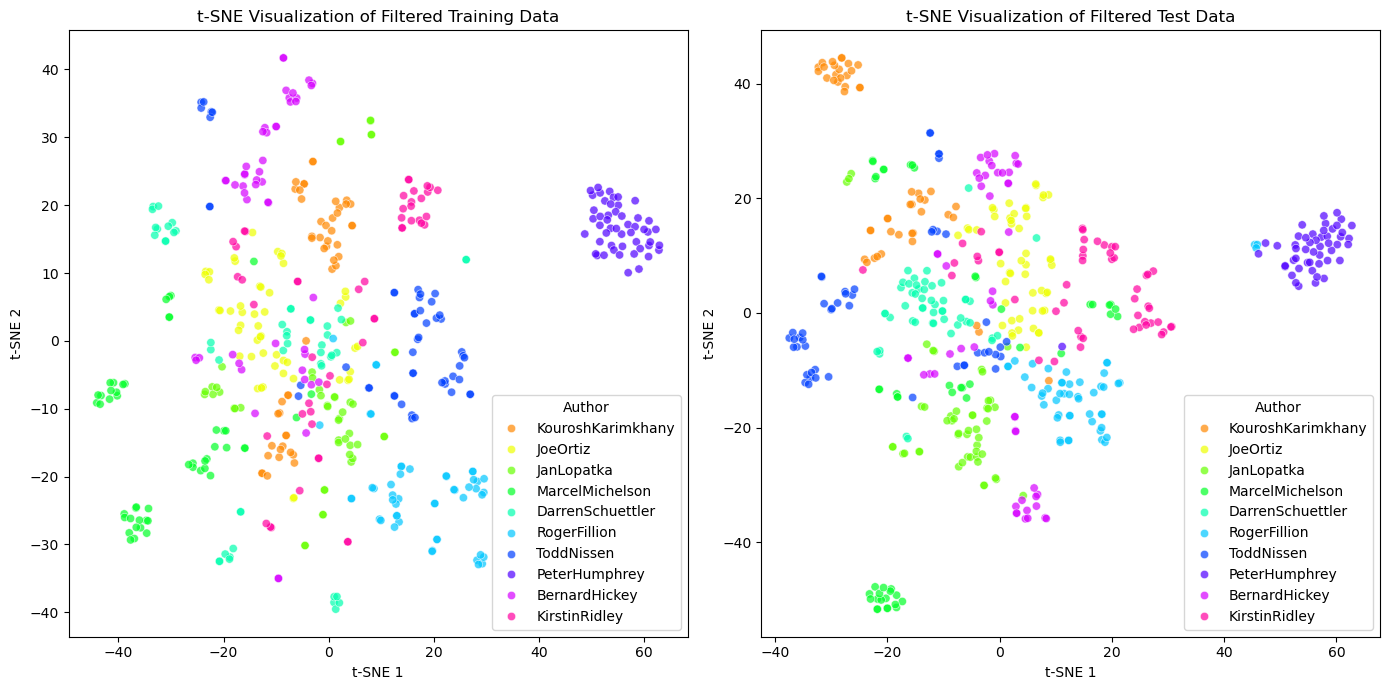

In [27]:
# Plotting the t-SNE results for the training data
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
sns.scatterplot(
    x='t-SNE 1', y='t-SNE 2',
    hue='Author',
    palette=sns.color_palette("hsv", len(set(train_filtered_labels))),
    data=train_tsne_df,
    legend="full",
    alpha=0.7
)
plt.title("t-SNE Visualization of Filtered Training Data")

# Plotting the t-SNE results for the test data
plt.subplot(1, 2, 2)
sns.scatterplot(
    x='t-SNE 1', y='t-SNE 2',
    hue='Author',
    palette=sns.color_palette("hsv", len(set(test_filtered_labels))),
    data=test_tsne_df,
    legend="full",
    alpha=0.7
)
plt.title("t-SNE Visualization of Filtered Test Data")

plt.tight_layout()
plt.show()

The t-SNE plot provides a visual representation of the similarities and differences in writing styles or content among the selected authors. The distinct clustering seen for certain authors supports the idea that author attribution can be effective using the features derived from the documents. However, the overlap between some clusters also suggests that there might be challenges in distinguishing between certain authors, indicating a need for more sophisticated methods or additional features to improve classification accuracy.

# feature Extraction Using TF-IDF

TF-IDF Vectorization on Both Train and Test Sets

In [28]:
# Initialize the TF-IDF Vectorizer (use the same vectorizer for both datasets to ensure consistency)
vectorizer = TfidfVectorizer(max_features=1000)

# Transform the training data
X_train = vectorizer.fit_transform(train_df['document']).toarray()

# Transform the test data using the same vectorizer
X_test = vectorizer.transform(test_df['document']).toarray()

# Convert the labels to numerical values if needed
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(train_df['author'])
y_test = le.fit_transform(test_df['author'])

# Get the vocabulary
vocab = vectorizer.get_feature_names_out()

# Convert the TF-IDF matrices to DataFrames for easier manipulation and inspection
tfidf_train_df = pd.DataFrame(X_train, columns=vocab)
tfidf_test_df = pd.DataFrame(X_test, columns=vocab)

Compute Cosine Similarity for Both Datasets

In [29]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute the cosine similarity matrix between the documents in the training set
cosine_sim_train_matrix = cosine_similarity(X_train)

# Compute the cosine similarity matrix between the documents in the test set
cosine_sim_test_matrix = cosine_similarity(X_test)

# Convert the cosine similarity matrices to DataFrames for easier inspection
cosine_sim_train_df = pd.DataFrame(cosine_sim_train_matrix, index=train_df['document'], columns=train_df['document'])
cosine_sim_test_df = pd.DataFrame(cosine_sim_test_matrix, index=test_df['document'], columns=test_df['document'])

In [30]:
# Example: Finding the most similar document to the first document in the training dataset
first_train_doc = train_df['document'].iloc[0]
most_similar_train_docs = cosine_sim_train_df[first_train_doc].sort_values(ascending=False)
print(f"Most similar documents to the first document in the training set:\n{most_similar_train_docs[1:6]}")

Most similar documents to the first document in the training set:
document
Revco D.S. Inc is expected to leverage its size and experience to overcome the host of problems that pushed regional drugstore chain Big B Inc into a deal with the Ohio-based drugstore giant.\nIndustry experts said Revco is well-placed to capture profits in the southeast by taking advantage of Big B's underused distribution center and closing overlapping stores in Georgia.\n"Revco will be able to integrate Big B really quickly," said Eric Bosshard of Midwest Research-Maxus Group.  \nThe two companies on Monday said that Big B had accepted a sweetened acquisition offer from Revco in a cash transaction valued at $380 million, or $17.25 per share.\nIt is the latest in a string of recent acquisitions in the drugstore industry. Just two weeks ago, Rite Aid Corp agreed to buy West Coast-based Thrifty PayLess Inc for $1.4 billion.\nBig B initially fought a takeover by Revco, rejecting its unsolicited bid of $15 per sha

In [31]:
# Example: Finding the most similar document to the first document in the test dataset
first_test_doc = test_df['document'].iloc[0]
most_similar_test_docs = cosine_sim_test_df[first_test_doc].sort_values(ascending=False)
print(f"Most similar documents to the first document in the test set:\n{most_similar_test_docs[1:6]}")

Most similar documents to the first document in the test set:
document
ITT Corp. met with financial advisers on Thursday to assess an unsolicited $6.5 billion bid from Hilton Hotels Corp., while some Wall Street analysts said the company's best defence might be to pursue an acquisition.\nIndustry experts said ITT might be able to stave off the takeover if it made a large casino or hotel purchase.\n"ITT is a company with a lot of friends on Wall Street and a lot of investment bankers and there are a lot of players in the gaming industry who would like to trade up to a higher quality," said Thomas Ryan of Bankers Trust.\nAlthough ITT is widely expected to reject the offer, sources close to the company said no decision had been made and no acquisition talks were being held. ITT's board will consider the bid at a regularly-scheduled board meeting next Tuesday.\nITT declined to comment.\nOn Monday, Hilton offered to buy ITT in a stock and cash transaction that values the company at $55 per 

In [32]:
# # Set up the figure for side-by-side plots
# plt.figure(figsize=(14, 6))

# # Plot the cosine similarity heatmap for the training data
# plt.subplot(1, 2, 1)
# sns.heatmap(cosine_sim_train_df, cmap='coolwarm', cbar=True)
# plt.title('Cosine Similarity Heatmap - Training Data')
# plt.xlabel('Documents')
# plt.ylabel('Documents')

# # Plot the cosine similarity heatmap for the test data
# plt.subplot(1, 2, 2)
# sns.heatmap(cosine_sim_test_df, cmap='coolwarm', cbar=True)
# plt.title('Cosine Similarity Heatmap - Test Data')
# plt.xlabel('Documents')
# plt.ylabel('Documents')

# # Adjust the layout and show the plot
# plt.tight_layout()
# plt.show()

Apply PCA and K-Means Clustering on Both Datasets

In [33]:
# Train
# Apply PCA on the training data
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

# Apply K-Means Clustering on the PCA-reduced training data
kmeans = KMeans(n_clusters=5, random_state=42)
train_clusters = kmeans.fit_predict(X_train_pca)

# Create a DataFrame for the PCA results
train_pca_df = pd.DataFrame(data=X_train_pca, columns=['PC1', 'PC2'])
train_pca_df['Cluster'] = train_clusters

# Test
# Apply PCA on the test data using the PCA model fitted on the training data
X_test_pca = pca.transform(X_test)

# Apply K-Means Clustering on the PCA-reduced test data using the same K-Means model fitted on the training data
test_clusters = kmeans.predict(X_test_pca)

# Create a DataFrame for the PCA results
test_pca_df = pd.DataFrame(data=X_test_pca, columns=['PC1', 'PC2'])
test_pca_df['Cluster'] = test_clusters

In [34]:
# Calculate silhouette score for training data
train_sil_score = silhouette_score(X_train_pca, train_clusters)
print(f'Training Silhouette Score: {train_sil_score}')

# Calculate silhouette score for test data
test_sil_score = silhouette_score(X_test_pca, test_clusters)
print(f'Test Silhouette Score: {test_sil_score}')

Training Silhouette Score: 0.3611998318711934
Test Silhouette Score: 0.36475427055533577


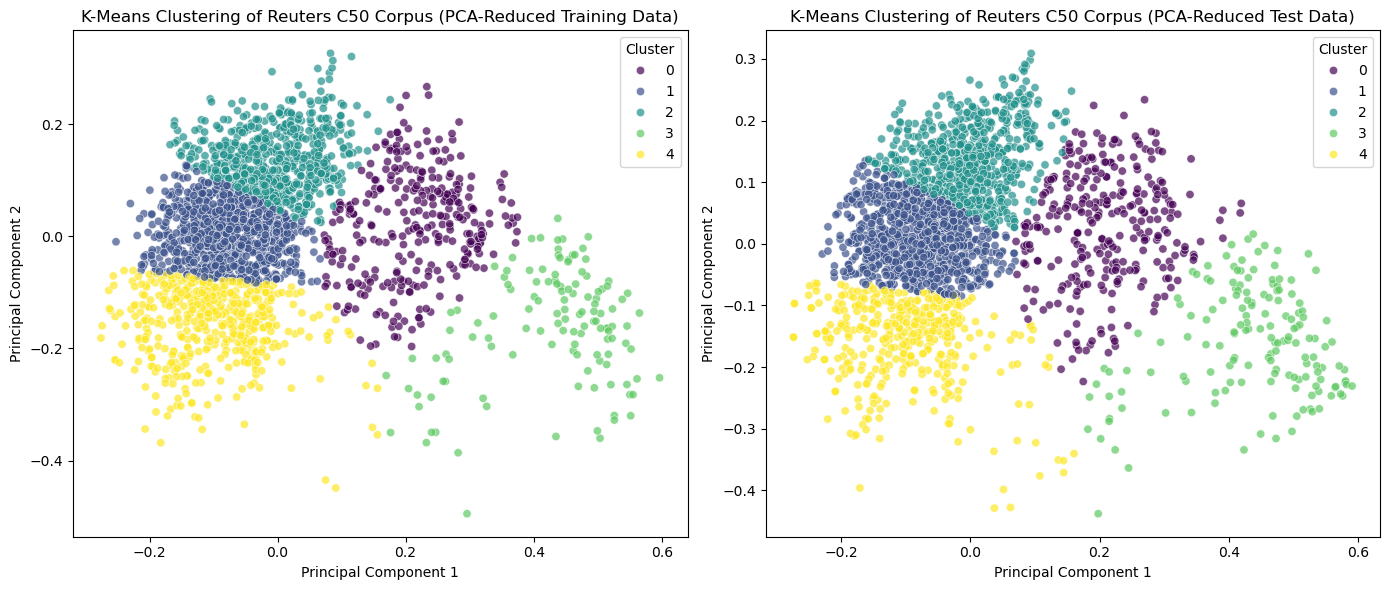

In [35]:
# Set up the figure for side-by-side plots
plt.figure(figsize=(14, 6))

# Plot the clusters for the training data
plt.subplot(1, 2, 1)
sns.scatterplot(
    x='PC1', y='PC2',
    hue='Cluster',
    palette=sns.color_palette('viridis', as_cmap=True),
    data=train_pca_df,
    legend='full',
    alpha=0.7
)
plt.title('K-Means Clustering of Reuters C50 Corpus (PCA-Reduced Training Data)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Plot the clusters for the test data
plt.subplot(1, 2, 2)
sns.scatterplot(
    x='PC1', y='PC2',
    hue='Cluster',
    palette=sns.color_palette('viridis', as_cmap=True),
    data=test_pca_df,
    legend='full',
    alpha=0.7
)
plt.title('K-Means Clustering of Reuters C50 Corpus (PCA-Reduced Test Data)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()